In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Chapter 9. Accessing NCBI’s Entrez databases

Entrez (https://www.ncbi.nlm.nih.gov/Web/Search/entrezfs.html) is a data retrieval system that provides users access to NCBI’s databases such as PubMed, GenBank, GEO, and many others. You can access Entrez from a web browser to manually enter queries, or you can use Biopython’s `Bio.Entrez` module for programmatic access to Entrez. The latter allows you for example to search PubMed or download GenBank records from within a Python script.

The `Bio.Entrez` module makes use of the Entrez Programming Utilities (also known as EUtils), consisting of eight tools that are described in detail on NCBI’s page at https://www.ncbi.nlm.nih.gov/books/NBK25501/.

The output returned by the Entrez Programming Utilities is typically in XML format. To parse such output, you have several options:
1. Use Bio.Entrez’s parser to parse the XML output into a Python object;
2. Use one of the XML parsers available in Python’s standard library;
3. Read the XML output as raw text, and parse it by string searching and manipulation.

NCBI uses DTD (Document Type Definition) files to describe the structure of the information contained in XML files. Most of the DTD files used by NCBI are included in the Biopython distribution. The Bio.Entrez parser makes use of the DTD files when parsing an XML file returned by NCBI Entrez.

Occasionally, you may find that the DTD file associated with a specific XML file is missing in the Biopython distribution. In particular, this may happen when NCBI updates its DTD files. If this happens, Entrez.read will show a warning message with the name and URL of the missing DTD file. Please download the DTD file from the URL in the warning message and place it in the directory `...site-packages/Bio/Entrez/DTDs`, containing the other DTD files. If you don’t have write access to this directory, you can also place the DTD file in `~/.biopython/Bio/Entrez/DTDs`.


## 9.1 Entrez Guidelines
Before using Biopython to access the NCBI’s online resources (via Bio.Entrez or some of the other modules), please read the [NCBI’s Entrez User Requirements](https://www.ncbi.nlm.nih.gov/books/NBK25497/). If the NCBI finds you are abusing their systems, they can and will ban your access!
* For any series of more than 100 requests, do this at weekends or outside USA peak times. This is up to you to obey.
* Use the https://eutils.ncbi.nlm.nih.gov address, not the standard NCBI Web address. Biopython uses this web address.
* If you are using a API key, you can make at most 10 queries per second, otherwise at most 3 queries per second. This is automatically enforced by Biopython. Include `api_key="MyAPIkey"` in the argument list or set it as a module level variable:
```
>>> from Bio import Entrez
>>> Entrez.api_key = "MyAPIkey"
```
* Use the optional email parameter so the NCBI can contact you if there is a problem. You can either explicitly set this as a parameter with each call to Entrez (e.g. include `email="A.N.Other@example.com"` in the argument list), or you can set a global email address:
```
>>> from Bio import Entrez
>>> Entrez.email = "A.N.Other@example.com"
```
Please DO NOT use a random email – it’s better not to give an email at all. The email parameter has been mandatory since June 1, 2010. In case of excessive usage, NCBI will attempt to contact a user at the e-mail address provided
prior to blocking access to the E-utilities.
* If you are using Biopython within some larger software suite, use the tool parameter to specify this. You can either explicitly set the tool name as a parameter with each call to Entrez (e.g. include `tool="MyLocalScript"` in the argument list), or you can set a global tool name:
```
>>> from Bio import Entrez
>>> Entrez.tool = "MyLocalScript"
```
* For large queries, the NCBI also recommend using their session history feature (the WebEnv session cookie string, see Section 9.16). This is only slightly more complicated.

In conclusion, be sensible with your usage levels. If you plan to download lots of data, consider other options. For example, if you want easy access to all the human genes, consider fetching each chromosome by FTP as a GenBank file, and importing these into your own BioSQL database (see Section 20.5).

## 9.2 EInfo: Obtaining information about the Entrez databases
EInfo provides field index term counts, last update, and available links for each of NCBI’s databases. In addition, you can use EInfo to obtain a list of all database names accessible through the Entrez utilities:

In [2]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
handle = Entrez.einfo()
result = handle.read()
handle.close()

In [3]:
print(result)

b'<?xml version="1.0" encoding="UTF-8" ?>\n<!DOCTYPE eInfoResult PUBLIC "-//NLM//DTD einfo 20190110//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20190110/einfo.dtd">\n<eInfoResult>\n<DbList>\n\n\t<DbName>pubmed</DbName>\n\t<DbName>protein</DbName>\n\t<DbName>nuccore</DbName>\n\t<DbName>ipg</DbName>\n\t<DbName>nucleotide</DbName>\n\t<DbName>structure</DbName>\n\t<DbName>genome</DbName>\n\t<DbName>annotinfo</DbName>\n\t<DbName>assembly</DbName>\n\t<DbName>bioproject</DbName>\n\t<DbName>biosample</DbName>\n\t<DbName>blastdbinfo</DbName>\n\t<DbName>books</DbName>\n\t<DbName>cdd</DbName>\n\t<DbName>clinvar</DbName>\n\t<DbName>gap</DbName>\n\t<DbName>gapplus</DbName>\n\t<DbName>grasp</DbName>\n\t<DbName>dbvar</DbName>\n\t<DbName>gene</DbName>\n\t<DbName>gds</DbName>\n\t<DbName>geoprofiles</DbName>\n\t<DbName>homologene</DbName>\n\t<DbName>medgen</DbName>\n\t<DbName>mesh</DbName>\n\t<DbName>nlmcatalog</DbName>\n\t<DbName>omim</DbName>\n\t<DbName>orgtrack</DbName>\n\t<DbName>pmc</DbName>\n

Since this is a fairly simple XML file, we could extract the information it contains simply by string searching. Using `Bio.Entrez`’s parser instead, we can directly parse this XML file into a Python object:

In [4]:
from Bio import Entrez
handle = Entrez.einfo()
record = Entrez.read(handle)

In [5]:
record.keys()

dict_keys(['DbList'])

In [6]:
record["DbList"]

['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'protfam', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']

For each of these databases, we can use EInfo again to obtain more information:

In [7]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
handle = Entrez.einfo(db="pubmed")
record = Entrez.read(handle)
record["DbInfo"]["Description"]
record["DbInfo"]["Count"]
record["DbInfo"]["LastUpdate"]

'2023/06/09 21:47'

In [8]:
for field in record["DbInfo"]["FieldList"]:
    print("%(Name)s, %(FullName)s, %(Description)s" % field)

ALL, All Fields, All terms from all searchable fields
UID, UID, Unique number assigned to publication
FILT, Filter, Limits the records
TITL, Title, Words in title of publication
MESH, MeSH Terms, Medical Subject Headings assigned to publication
MAJR, MeSH Major Topic, MeSH terms of major importance to publication
JOUR, Journal, Journal abbreviation of publication
AFFL, Affiliation, Author's institutional affiliation and address
ECNO, EC/RN Number, EC number for enzyme or CAS registry number
SUBS, Supplementary Concept, CAS chemical name or MEDLINE Substance Name
PDAT, Date - Publication, Date of publication
EDAT, Date - Entry, Date publication first accessible through Entrez
VOL, Volume, Volume number of publication
PAGE, Pagination, Page number(s) of publication
PTYP, Publication Type, Type of publication (e.g., review)
LANG, Language, Language of publication
ISS, Issue, Issue number of publication
SUBH, MeSH Subheading, Additional specificity for MeSH term
SI, Secondary Source ID, Cr

## 9.3 ESearch: Searching the Entrez databases

In [9]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
handle = Entrez.esearch(db="pubmed", term="biopython[title]", retmax="40")
record = Entrez.read(handle)
"19304878" in record["IdList"]

True

In [10]:
print(record["IdList"])

['34434786', '22909249', '19304878']


You can also use ESearch to search GenBank.

In [11]:
handle = Entrez.esearch(
    db="nucleotide", term="Cypripedioideae[Orgn] AND matK[Gene]", idtype="acc"
)
record = Entrez.read(handle)
record["Count"]
record["IdList"]

['NC_063680.1', 'NC_064145.1', 'NC_063681.1', 'NC_066405.1', 'OP465215.1', 'NC_071758.1', 'NC_069974.1', 'NC_069973.1', 'NC_069972.1', 'NC_069971.1', 'NC_069970.1', 'NC_069969.1', 'NC_069968.1', 'NC_069967.1', 'NC_069966.1', 'NC_069965.1', 'NC_069964.1', 'NC_069963.1', 'NC_069962.1', 'NC_069961.1']

Let’s get a list of computational journal titles:

In [12]:
handle = Entrez.esearch(db="nlmcatalog", term="computational[Journal]", retmax="20")
record = Entrez.read(handle)
print("{} computational journals found".format(record["Count"]))
print("The first 20 are\n{}".format(record["IdList"]))

193 computational journals found
The first 20 are
['474444', '101775780', '101775476', '101775136', '471899', '470813', '297158', '203194', '96920', '388333', '101768752', '101765300', '101759185', '101752828', '296882', '101768811', '101755127', '101753951', '101753371', '101737789']


## 9.4. EPost: Uploading a list of identifiers
EPost uploads a list of UIs for use in subsequent search strategies; see the [EPost help page](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EPost) for more information. It is available from Biopython through the `Bio.Entrez.epost()` function.

To give an example of when this is useful, suppose you have a long list of IDs you want to download using EFetch (maybe sequences, maybe citations – anything). When you make a request with EFetch your list of IDs, the database etc, are all turned into a long URL sent to the server. If your list of IDs is long, this URL gets long, and long URLs can break (e.g. some proxies don’t cope well).

Instead, you can break this up into two steps, first uploading the list of IDs using EPost (this uses an “HTML post” internally, rather than an “HTML get”, getting round the long URL problem). With the history support, you can then refer to this long list of IDs, and download the associated data with EFetch.

Let’s look at a simple example to see how EPost works – uploading some PubMed identifiers:

In [13]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
id_list = ["19304878", "18606172", "16403221", "16377612", "14871861", "14630660"]
print(Entrez.epost("pubmed", id=",".join(id_list)).read())

b'<?xml version="1.0" encoding="UTF-8" ?>\n<!DOCTYPE ePostResult PUBLIC "-//NLM//DTD epost 20090526//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20090526/epost.dtd"><ePostResult>\n\t<QueryKey>1</QueryKey>\n\t<WebEnv>MCID_64841a68abfb8e24641266f5</WebEnv>\n</ePostResult>\n'


The returned XML includes two important strings, QueryKey and WebEnv which together define your history session. You would extract these values for use with another Entrez call such as EFetch:

In [14]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
id_list = ["19304878", "18606172", "16403221", "16377612", "14871861", "14630660"]
search_results = Entrez.read(Entrez.epost("pubmed", id=",".join(id_list)))
webenv = search_results["WebEnv"]
query_key = search_results["QueryKey"]

## 9.5 ESummary: Retrieving summaries from primary IDs
ESummary retrieves document summaries from a list of primary IDs (see the [ESummary help page](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESummary) for more information). In Biopython, ESummary is available as `Bio.Entrez.esummary()`. Using the search result above, we can for example find out more about the journal with ID 30367:

In [15]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esummary(db="nlmcatalog", id="101660833")
record = Entrez.read(handle)
info = record[0]["TitleMainList"][0]
print("Journal info\nid: {}\nTitle: {}".format(record[0]["Id"], info["Title"]))

Journal info
id: 101660833
Title: IEEE transactions on computational imaging.


## 9.6 EFetch: Downloading full records from Entrez
EFetch is what you use when you want to retrieve a full record from Entrez. This covers several possible databases, as described on the main [EFetch Help page](https://www.ncbi.nlm.nih.gov/books/NBK3837/).
For most of their databases, the NCBI support several different file formats. Requesting a specific file format from Entrez using `Bio.Entrez.efetch()` requires specifying the `rettype` and/or `retmode` optional arguments.

From the Cypripedioideae example above, we can download GenBank record EU490707 using `Bio.Entrez.efetch`:

In [16]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.efetch(db="nucleotide", id="EU490707", rettype="gb", retmode="text")
print(handle.read())

LOCUS       EU490707                1302 bp    DNA     linear   PLN 26-JUL-2016
DEFINITION  Selenipedium aequinoctiale maturase K (matK) gene, partial cds;
            chloroplast.
ACCESSION   EU490707
VERSION     EU490707.1
KEYWORDS    .
SOURCE      chloroplast Selenipedium aequinoctiale
  ORGANISM  Selenipedium aequinoctiale
            Eukaryota; Viridiplantae; Streptophyta; Embryophyta; Tracheophyta;
            Spermatophyta; Magnoliopsida; Liliopsida; Asparagales; Orchidaceae;
            Cypripedioideae; Selenipedium.
REFERENCE   1  (bases 1 to 1302)
  AUTHORS   Neubig,K.M., Whitten,W.M., Carlsward,B.S., Blanco,M.A., Endara,L.,
            Williams,N.H. and Moore,M.
  TITLE     Phylogenetic utility of ycf1 in orchids: a plastid gene more
            variable than matK
  JOURNAL   Plant Syst. Evol. 277 (1-2), 75-84 (2009)
REFERENCE   2  (bases 1 to 1302)
  AUTHORS   Neubig,K.M., Whitten,W.M., Carlsward,B.S., Blanco,M.A.,
            Endara,C.L., Williams,N.H. and Moore,M.J.
  TIT

Please be aware that as of October 2016 GI identifiers are discontinued in favor of accession numbers. You can still fetch sequences based on their GI, but new sequences are no longer given this identifier. You should instead refer to them by the “Accession number” as done in the example.

The arguments `rettype="gb"` and `retmode="text"` let us download this record in the GenBank format. You could for example use `rettype="fasta"` to get the Fasta-format; see the [EFetch Sequences Help page](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EFetch) for other options. Remember – the available formats depend on which database you are downloading from - see the main [EFetch Help page](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EFetch).

In [17]:
from Bio import SeqIO
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.efetch(db="nucleotide", id="EU490707", rettype="gb", retmode="text")
record = SeqIO.read(handle, "genbank")
handle.close()
print(record.id)
print(record.name)
print(record.description)
print(len(record.features))
record.seq

EU490707.1
EU490707
Selenipedium aequinoctiale maturase K (matK) gene, partial cds; chloroplast
3


Seq('ATTTTTTACGAACCTGTGGAAATTTTTGGTTATGACAATAAATCTAGTTTAGTA...GAA')

Note that a more typical use would be to save the sequence data to a local file, and then parse it with `Bio.SeqIO`. This can save you having to re-download the same file repeatedly while working on your script, and places less load on the NCBI’s servers.

In [18]:
import os
from Bio import SeqIO
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
filename = "EU490707.gbk"
if not os.path.isfile(filename):
    # Downloading...
    net_handle = Entrez.efetch(
        db="nucleotide", id="EU490707", rettype="gb", retmode="text"
    )
    out_handle = open(filename, "w")
    out_handle.write(net_handle.read())
    out_handle.close()
    net_handle.close()
    print("Saved")
print("Parsing...")
record = SeqIO.read(filename, "genbank")
print(record)

Parsing...
ID: EU490707.1
Name: EU490707
Description: Selenipedium aequinoctiale maturase K (matK) gene, partial cds; chloroplast
Number of features: 3
/molecule_type=DNA
/topology=linear
/data_file_division=PLN
/date=26-JUL-2016
/accessions=['EU490707']
/sequence_version=1
/keywords=['']
/source=chloroplast Selenipedium aequinoctiale
/organism=Selenipedium aequinoctiale
/taxonomy=['Eukaryota', 'Viridiplantae', 'Streptophyta', 'Embryophyta', 'Tracheophyta', 'Spermatophyta', 'Magnoliopsida', 'Liliopsida', 'Asparagales', 'Orchidaceae', 'Cypripedioideae', 'Selenipedium']
/references=[Reference(title='Phylogenetic utility of ycf1 in orchids: a plastid gene more variable than matK', ...), Reference(title='Direct Submission', ...)]
Seq('ATTTTTTACGAACCTGTGGAAATTTTTGGTTATGACAATAAATCTAGTTTAGTA...GAA')


In [19]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.efetch(db="nucleotide", id="EU490707", retmode="xml") # To get the output in XML format
record = Entrez.read(handle)
handle.close()
record[0]["GBSeq_definition"]
record[0]["GBSeq_source"]

'chloroplast Selenipedium aequinoctiale'

## 9.7 ELink: Searching for related items in NCBI Entrez
ELink, available from Biopython as `Bio.Entrez.elink()`, can be used to find related items in the NCBI Entrez databases. For example, you can us this to find nucleotide entries for an entry in the gene database, and other cool stuff.
For help on ELink, see the [ELink help page](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ELink). There is an entire sub-page just for the [link names](https://eutils.ncbi.nlm.nih.gov/corehtml/query/static/entrezlinks.html), describing how different databases can be cross referenced.
Let’s use ELink to find articles related to the Biopython application note published in Bioinformatics in 2009. The PubMed ID of this article is 19304878:

In [20]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
pmid = "19304878"
record = Entrez.read(Entrez.elink(dbfrom="pubmed", id=pmid))

In [21]:
record[0]["DbFrom"]
record[0]["IdList"]

['19304878']

The "`LinkSetDb`" key contains the search results, stored as a list consisting of one item for each target database.

In [22]:
len(record[0]["LinkSetDb"])

8

In [23]:
for linksetdb in record[0]["LinkSetDb"]:
    print(linksetdb["DbTo"], linksetdb["LinkName"], len(linksetdb["Link"]))

pubmed pubmed_pubmed 200
pubmed pubmed_pubmed_alsoviewed 19
pubmed pubmed_pubmed_citedin 1752
pubmed pubmed_pubmed_combined 6
pubmed pubmed_pubmed_five 6
pubmed pubmed_pubmed_refs 17
pubmed pubmed_pubmed_reviews 10
pubmed pubmed_pubmed_reviews_five 6


In [24]:
record[0]["LinkSetDb"][0]["Link"][0]
record[0]["LinkSetDb"][0]["Link"][1]

{'Id': '14630660'}

This paper, with PubMed ID 14630660, is about the Biopython PDB parser.
We can use a loop to print out all PubMed IDs:

In [25]:
for link in record[0]["LinkSetDb"][0]["Link"]:
    print(link["Id"])

19304878
14630660
22909249
20739307
31278684
23023984
25273102
18689808
23842806
20847218
18251993
20733063
19628504
15572471
22399473
31310539
20823319
12368254
29253085
20421198
30285630
24064416
25236461
35617194
22332238
16377612
18238804
14512356
22581176
22302572
12230038
32637988
25661541
15096277
15723693
21216774
32044951
23633579
18593718
15130828
17237069
24463182
33341884
21352538
28407033
29641230
20973958
19181685
17441614
28302053
26030926
23456039
29048466
32960970
22815363
18227118
22368248
17101041
20591906
17384428
16539535
20334363
22824207
18252737
20375454
14751976
16257987
23479348
31650686
14871861
25677125
15969769
25414366
32935829
27493193
21949271
22500002
17237072
26446134
37277726
24885957
32407511
27153673
29236954
22276101
17537750
26394715
15059834
19773334
30735498
30235322
19106120
19460889
22877863
26079347
29558112
15980554
28333216
20537149
19698094
23292976
21385461
28472272
21210978
24564380
22556367
31778155
21798964
22396485
28334266
35403803
2

## 9.8 EGQuery: Global Query - counts for search terms
EGQuery provides counts for a search term in each of the Entrez databases (i.e. a global query). This is particularly useful to find out how many items your search terms would find in each database without actually performing lots of separate searches with ESearch (see the example in 9.15.2 below).
See the [EGQuery help page](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EGQuery) for more information.
In this example, we use `Bio.Entrez.egquery()` to obtain the counts for “Biopython”:

In [26]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.egquery(term="biopython")
record = Entrez.read(handle)

In [27]:
for row in record["eGQueryResult"]:
    print(row["DbName"], row["Count"])

pubmed 42
pmc 2887
mesh 0
books 2
pubmedhealth Error
omim 0
ncbisearch 1
nuccore 3
nucgss 0
nucest 0
protein 0
genome 0
structure 0
taxonomy 0
snp 0
dbvar 0
gene 0
sra 2234
biosystems Error
unigene 0
cdd 0
clone 0
popset 0
geoprofiles 0
gds 17
homologene 0
pccompound 0
pcsubstance 0
pcassay 0
nlmcatalog 0
probe 0
gap 0
proteinclusters 0
bioproject 1
biosample 0
biocollections 0


## 9.9 ESpell: Obtaining spelling suggestions
ESpell retrieves spelling suggestions. See the [ESpell help page](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESpell) for more information. In this example, we use `Bio.Entrez.espell()` to obtain the correct spelling of Biopython:

In [28]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.espell(term="biopythooon")
record = Entrez.read(handle)
record["Query"]
record["CorrectedQuery"]

'biopython'

## 9.10 Parsing huge Entrez XML files
The `Entrez.read` function reads the entire XML file returned by Entrez into a single Python object, which is kept in memory. To parse Entrez XML files too large to fit in memory, you can use the function `Entrez.parse`.

For example, the file, which is in the `ASN` format, can be converted into an XML file using NCBI’s `gene2xml` program (see NCBI’s ftp site for more information):
```
$ wget ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/ASN_BINARY/Mammalia/Homo_sapiens.ags.gz
$ gzip -d Homo_sapiens.ags.gz
$ gene2xml -b T -i Homo_sapiens.ags -o Homo_sapiens.xml
```
The resulting XML file has a size of 6.1 GB. Attempting Entrez.read on this file will result in a MemoryError on many computers.

The XML file `Homo_sapiens.xml` consists of a list of Entrez gene records, each corresponding to one Entrez gene in human. `Entrez.parse` retrieves these gene records one by one.

In [29]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
handle = open("Homo_sapiens.xml", "rb")
records = Entrez.parse(handle)
for idx, record in enumerate(records):
    status = record["Entrezgene_track-info"]["Gene-track"]["Gene-track_status"]
    if status.attributes["value"] == "discontinued":
        continue
    geneid = record["Entrezgene_track-info"]["Gene-track"]["Gene-track_geneid"]
    genename = record["Entrezgene_gene"]["Gene-ref"]["Gene-ref_locus"]
    print(geneid, genename)
    if idx > 50:
        break

1 A1BG
2 A2M
3 A2MP1
8 AA
9 NAT1
10 NAT2
11 NATP
12 SERPINA3
13 AADAC
14 AAMP
15 AANAT
16 AARS1
17 AAVS1
18 ABAT
19 ABCA1
20 ABCA2
21 ABCA3
22 ABCB7
23 ABCF1
24 ABCA4
25 ABL1
26 AOC1
27 ABL2
28 ABO
29 ABR
30 ACAA1
31 ACACA
32 ACACB
33 ACADL
34 ACADM
35 ACADS
36 ACADSB
37 ACADVL
38 ACAT1
39 ACAT2
40 ASIC2
41 ASIC1
42 ACHAP
43 ACHE
44 ACHM2
45 ACHM3
46 ACLS
47 ACLY
48 ACO1
49 ACR
50 ACO2
51 ACOX1
52 ACP1


## 9.11 HTML excape characters
Pubmed records may contain HTML tags to indicate e.g. subscripts, superscripts, or italic text, as well as mathematical symbols via MathML. By default, the `Bio.Entrez` parser treats all text as plain text without markup; for example, the fragment “P < 0.05” in the abstract of a Pubmed record, which is encoded as
```
<i>P</i> &lt; 0.05
```
in the XML returned by Entrez, is converted to the Python string
```
'<i>P</i> < 0.05'
```
by the `Bio.Entrez` parser.

To ensure that all strings returned by the parser are valid HTML, call `Entrez.read` or `Entrez.parse` with the `escape` argument set to `True`:

In [30]:
from Bio import Entrez
handle = open("Homo_sapiens.xml", "rb")
record = Entrez.parse(handle, escape=True) # or Entrez.read(handle, escape=True)

By default, `escape` is `False`.

## 9.12 Handling errors
Three things can go wrong when parsing an XML file:
* The file may not be an XML file to begin with;
* The file may end prematurely or otherwise be corrupted;
* The file may be correct XML, but contain items that are not represented in the associated DTD.

In [31]:
from Bio import Entrez
handle = open("NC_005816.fna", "rb") # a Fasta file
record = Entrez.read(handle)  # Bio.Entrez.Parser.NotXMLError: Failed to parse the XML data (syntax error: line 1, column 0). Please mak

NotXMLError: Failed to parse the XML data (syntax error: line 1, column 0). Please make sure that the input data are in XML format.

Here, the parser didn’t find the `<?xml ...` tag with which an XML file is supposed to start, and therefore decides (correctly) that the file is not an XML file.

When your file is in the XML format but is corrupted (for example, by ending prematurely), the parser will raise a CorruptedXMLError. Here is an example of an XML file that ends prematurely:
```
<?xml version="1.0"?>
<!DOCTYPE eInfoResult PUBLIC "-//NLM//DTD eInfoResult, 11 May 2002//EN" "https://www.ncbi.nlm.nih.gov/en
<eInfoResult>
<DbList>
    <DbName>pubmed</DbName>
    <DbName>protein</DbName>
    <DbName>nucleotide</DbName>
    <DbName>nuccore</DbName>
    <DbName>nucgss</DbName>
    <DbName>nucest</DbName>
    <DbName>structure</DbName>
    <DbName>genome</DbName>
    <DbName>books</DbName>
    <DbName>cancerchromosomes</DbName>
    <DbName>cdd</DbName>
```

which will generate the following traceback:
```
>>> Entrez.read(handle)
Traceback (most recent call last):
    ...
Bio.Entrez.Parser.CorruptedXMLError: Failed to parse the XML data (no element found: line 16, column 0).
```

The third type of error occurs if the XML file contains tags that do not have a description in the corresponding DTD file. This is an example of such an XML file:
```
<?xml version="1.0"?>
<!DOCTYPE eInfoResult PUBLIC "-//NLM//DTD eInfoResult, 11 May 2002//EN" "https://www.ncbi.nlm.nih.gov/entrez/query/DTD/eInfo_020511.dtd">
<eInfoResult>
    <DbInfo>
    <DbName>pubmed</DbName>
    <MenuName>PubMed</MenuName>
    <Description>PubMed bibliographic record</Description>
    <Count>20161961</Count>
    <LastUpdate>2010/09/10 04:52</LastUpdate>
    <FieldList>
        <Field>
            ...
        </Field>
    </FieldList>
    <DocsumList>
        <Docsum>
            <DsName>PubDate</DsName>
            <DsType>4</DsType>
            <DsTypeName>string</DsTypeName>
        </Docsum>
        <Docsum>
            <DsName>EPubDate</DsName>
            ...
        </Docsum>
    </DocsumList>
    </DbInfo>
</eInfoResult>
```
* To download test file : [`einfo3.xml`](https://github.com/biopython/biopython/blob/master/Tests/Entrez/einfo3.xml)

In this file, for some reason the tag `<DocsumList>` (and several others) are not listed in the DTD file `eInfo_020511.dtd`, which is specified on the second line as the DTD for this XML file. By default, the parser will stop and raise a ValidationError if it cannot find some tag in the DTD:

In [32]:
from Bio import Entrez
handle = open("einfo3.xml", "rb")
record = Entrez.read(handle) # Bio.Entrez.Parser.ValidationError: Failed to find tag 'DocsumList' in the DTD. To skip all tags that are

ValidationError: Failed to find tag 'DocsumList' in the DTD. To skip all tags that are not represented in the DTD, please call Bio.Entrez.read or Bio.Entrez.parse with validate=False.

Optionally, you can instruct the parser to skip such tags instead of raising a ValidationError.

In [33]:
from Bio import Entrez
handle = open("einfo3.xml", "rb")
record = Entrez.read(handle, validate=False)
handle.close()

## 9.13 Specialized parsers
To request a specific file format from Entrez using `Bio.Entrez.efetch()` requires specifying the `rettype` and/or `retmode` optional arguments. The different combinations are described for each database type on the [NCBI efetch webpage](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EFetch).

One obvious case is you may prefer to download sequences in the FASTA or GenBank/GenPept plain text formats (which can then be parsed with `Bio.SeqIO`, see Sections 5.3.1 and 9.6). For the literature databases, Biopython contains a parser for the `MEDLINE` format used in PubMed.

### 9.13.1 Parsing Medline records
You can find the Medline parser in Bio.Medline. Suppose we want to parse the file [`pubmed_result1.txt`](https://github.com/biopython/biopython/blob/master/Tests/Medline/pubmed_result1.txt),
containing one Medline record. You can find this file in Biopython’s [`Tests/Medline`](https://github.com/biopython/biopython/tree/master/Tests/Medline) directory. The file looks
like this:
```
PMID- 12230038
OWN - NLM
STAT- MEDLINE
DA  - 20020916
DCOM- 20030606
LR  - 20041117
PUBM- Print
IS  - 1467-5463 (Print)
VI  - 3
IP  - 3
DP  - 2002 Sep
TI  - The Bio* toolkits--a brief overview.
PG  - 296-302
AB  - Bioinformatics research is often difficult to do with commercial software. The
Open Source BioPerl, BioPython and Biojava projects provide toolkits with
...

```

In [34]:
from Bio import Medline
with open("pubmed_result1.txt") as handle:
    record = Medline.read(handle)

In [35]:
record["PMID"]

'12230038'

In [36]:
record["AB"]

'Bioinformatics research is often difficult to do with commercial software. The Open Source BioPerl, BioPython and Biojava projects provide toolkits with'

The key names used in a Medline record can be rather obscure; use
```
>>> help(record)
```
for a brief summary.

To parse a file containing multiple Medline records, you can use the `parse` function instead:

In [37]:
from Bio import Medline
with open("pubmed_result2.txt") as handle:
    for record in Medline.parse(handle):
        print(record["TI"])

A high level interface to SCOP and ASTRAL implemented in python.
GenomeDiagram: a python package for the visualization of large-scale genomic data.
Open source clustering software.
PDB file parser and structure class implemented in Python.


Instead of parsing Medline records stored in files, you can also parse Medline records downloaded by `Bio.Entrez.efetch`.

In [38]:
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(db="pubmed", term="biopython")
record = Entrez.read(handle)
record["IdList"]

['36818783', '36245797', '36094101', '35497637', '35496474', '35402671', '34735950', '34484417', '34434786', '34189012', '33994075', '33902722', '33809815', '33242467', '32044951', '31762715', '31278684', '31069053', '30013827', '29641230']

In [39]:
idlist = record["IdList"]
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")

Now we use `Bio.Medline` to parse these records:

In [40]:
from Bio import Medline
records = Medline.parse(handle)
for record in records:
    print(record["AU"])

['Olds CG', 'Berta-Thompson JW', 'Loucks JJ', 'Levy RA', 'Wilson AW']
['Nallasamy V', 'Seshiah M']
['Rashid S', 'Ng TA', 'Kwoh CK']
['He L', 'Cornish TC', 'Kricka LJ', 'Vandergriff TW', 'Yancey K', 'Nguyen K', 'Park JY']
['Scott S', 'Grigson S', 'Hartkopf F', 'Hallwirth CV', 'Alexander IE', 'Bauer DC', 'Wilson LOW']
['Omonhinmin C', 'Onuselogu C']
['Zelenova M', 'Ivanova A', 'Semyonov S', 'Gankin Y']
['Li Y', 'Wang J', 'Li Y', 'Liu C', 'Gong X', 'Zhuang Y', 'Chen L', 'Sun K']
['Cornish TC', 'Kricka LJ', 'Park JY']
['Purohit S', 'Satapathy SC', 'Sibi Chakkaravarthy S', 'Zhang YD']
['Floch A', 'Teletchea S', 'Tournamille C', 'de Brevern AG', 'Pirenne F']
['Torkian B', 'Hann S', 'Preisner E', 'Norman RS']
['Ochoa R', 'Cossio P']
['Kricka LJ', 'Cornish TC', 'Park JY']
['Ireland SM', 'Martin ACR']
['Chen G', 'Feng Y', 'Sun Z', 'Gao Y', 'Wu C', 'Zhang H', 'Cao J', 'Chen Z', 'Cao J', 'Zhu Y', 'Zhang S']
['Bonnal RJP', 'Yates A', 'Goto N', 'Gautier L', 'Willis S', 'Fields C', 'Katayama T', 'Pr

In [41]:
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="xml")
records = Entrez.read(handle)
for record in records["PubmedArticle"]:
    print(record["MedlineCitation"]["Article"]["ArticleTitle"])

Applying a modified metabarcoding approach for the sequencing of macrofungal specimens from fungarium collections.
Energy Profile Bayes and Thompson Optimized Convolutional Neural Network protein structure prediction.
Jupytope: computational extraction of structural properties of viral epitopes.
Trends in dermatology eponyms.
A bioinformatic pipeline for simulating viral integration data.
<i>rbcL</i> gene in global molecular data repository.
Analysis of 329,942 SARS-CoV-2 records retrieved from GISAID database.
Identification of Immune-Related Genes in Sepsis due to Community-Acquired Pneumonia.
A Biopython-based method for comprehensively searching for eponyms in Pubmed.
Correlation-Based Analysis of COVID-19 Virus Genome Versus Other Fatal Virus Genomes.
A Review of the Literature Organized Into a New Database: RHeference.
BLAST-QC: automated analysis of BLAST results.
PepFun: Open Source Protocols for Peptide-Related Computational Analysis.
Eponyms in clinical chemistry.
atomium-a P

### 9.13.2 Parsing GEO records
GEO ([Gene Expression Omnibus](https://www.ncbi.nlm.nih.gov/geo/)) is a data repository of high-throughput gene expression and hybridization array data. The `Bio.Geo` module can be used to parse GEO-formatted data.
The following code fragment shows how to parse the example GEO file `GSE16.txt` into a record and print the record:
* To download test file : [`GSE16.txt`](https://github.com/biopython/biopython/blob/master/Tests/Geo/GSE16.txt)

In [42]:
from Bio import Geo
handle = open("GSE16.txt")
records = Geo.parse(handle)
for record in records:
    print(record)

GEO Type: SAMPLE
GEO Id: GSM804
Sample_author: Antoine,M,Snijders

Sample_author: Norma,,Nowak

Sample_author: Richard,,Segraves

Sample_author: Stephanie,,Blackwood

Sample_author: Nils,,Brown

Sample_author: Jeffery,,Conroy

Sample_author: Greg,,Hamilton

Sample_author: Anna,K,Hindle

Sample_author: Bing,,Huey

Sample_author: Karen,,Kimura

Sample_author: Sindy,,Law

Sample_author: Ken,,Myambo

Sample_author: Joel,,Palmer

Sample_author: Bauke,,Ylstra

Sample_author: Jingzhu,P,Yue

Sample_author: Joe,W,Gray

Sample_author: Ajay,N,Jain

Sample_author: Daniel,,Pinkel

Sample_author: Donna,G,Albertson

Sample_description: Coriell Cell Repositories cell line <a h
ref="http://locus.umdnj.edu/nigms/nigms_cgi/display.cgi?GM05296">GM05296</a>.

Sample_description: Fibroblast cell line derived from a 1 mo
nth old female with multiple congenital malformations, dysmorphic features, intr
auterine growth retardation, heart murmur, cleft palate, equinovarus deformity, 
microcephaly, coloboma of ri

You can search the “gds” database (GEO datasets) with ESearch:

In [43]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(db="gds", term="GSE16")
record = Entrez.read(handle)
handle.close()
record["Count"]
record["IdList"]

['200000016', '100000028', '300000818', '300000817', '300000816', '300000815', '300000814', '300000813', '300000812', '300000811', '300000810', '300000809', '300000808', '300000807', '300000806', '300000805', '300000804', '300000803', '300000802', '300000801']

From the Entrez website, UID “200000016” is GDS16 while the other hit “100000028” is for the associated platform, GPL28. Unfortunately, at the time of writing the NCBI don’t seem to support downloading GEO files using Entrez (not as XML, nor in the Simple Omnibus Format in Text (SOFT) format).
However, it is actually pretty straight forward to download the GEO files by FTP from ftp://ftp.ncbi.nih.gov/pub/geo/ instead. In this case you might want ftp://ftp.ncbi.nih.gov/pub/geo/DATA/SOFT/by_series/GSE16/GSE16_family.soft.gz (a compressed file, see the Python module gzip).

### 9.13.3 Parsing UniGene records
UniGene is an NCBI database of the transcriptome, with each UniGene record showing the set of transcripts that are associated with a particular gene in a specific organism. A typical UniGene record looks like this:
```
ID         Hs.2
TITLE      N-acetyltransferase 2 (arylamine N-acetyltransferase)
GENE       NAT2
CYTOBAND   8p22
GENE_ID    10
LOCUSLINK  10
HOMOL      YES
EXPRESS    bone| connective tissue| intestine| liver| liver tumor| normal| soft tissue/muscle tissue t
RESTR_EXPR adult
CHROMOSOME 8
STS        ACC=PMC310725P3 UNISTS=272646
STS        ACC=WIAF-2120 UNISTS=44576
STS        ACC=G59899 UNISTS=137181
...
STS        ACC=GDB:187676 UNISTS=155563
PROTSIM    ORG=10090; PROTGI=6754794; PROTID=NP_035004.1; PCT=76.55; ALN=288
PROTSIM    ORG=9796; PROTGI=149742490; PROTID=XP_001487907.1; PCT=79.66; ALN=288
PROTSIM    ORG=9986; PROTGI=126722851; PROTID=NP_001075655.1; PCT=76.90; ALN=288
...
PROTSIM    ORG=9598; PROTGI=114619004; PROTID=XP_519631.2; PCT=98.28; ALN=288

SCOUNT     38
SEQUENCE   ACC=BC067218.1; NID=g45501306; PID=g45501307; SEQTYPE=mRNA
SEQUENCE   ACC=NM_000015.2; NID=g116295259; PID=g116295260; SEQTYPE=mRNA
SEQUENCE   ACC=D90042.1; NID=g219415; PID=g219416; SEQTYPE=mRNA
SEQUENCE   ACC=D90040.1; NID=g219411; PID=g219412; SEQTYPE=mRNA
SEQUENCE   ACC=BC015878.1; NID=g16198419; PID=g16198420; SEQTYPE=mRNA
SEQUENCE   ACC=CR407631.1; NID=g47115198; PID=g47115199; SEQTYPE=mRNA
SEQUENCE   ACC=BG569293.1; NID=g13576946; CLONE=IMAGE:4722596; END=5'; LID=6989; SEQTYPE=EST; TRACE=441
...
SEQUENCE   ACC=AU099534.1; NID=g13550663; CLONE=HSI08034; END=5'; LID=8800; SEQTYPE=EST
//
```
This particular record shows the set of transcripts (shown in the `SEQUENCE` lines) that originate from the human gene NAT2, encoding en N-acetyltransferase. The `PROTSIM` lines show proteins with significant similarity to NAT2, whereas the `STS` lines show the corresponding equence-tagged sites in the genome.

To parse UniGene files, use the `Bio.UniGene` module:

In [44]:
from Bio import UniGene
input = open("myunigenefile.data")
record = UniGene.read(input)

The `record` returned by `UniGene.read` is a Python object with attributes corresponding to the fields in the UniGene record. For example,

In [45]:
record.ID

'Hs.2'

In [46]:
record.title

'N-acetyltransferase 2 (arylamine N-acetyltransferase)'

The `EXPRESS` and `RESTR_EXPR` lines are stored as Python lists of strings:
```
[
    "bone",
    "connective tissue",
    "intestine",
    "liver",
    "liver tumor",
    "normal",
    "soft tissue/muscle tissue tumor",
    "adult",
]
```
Specialized objects are returned for the `STS`, `PROTSIM`, and `SEQUENCE` lines, storing the keys shown in each line as attributes:

In [47]:
record.sts[0].acc

'PMC310725P3'

In [48]:
record.sts[0].unists

'272646'

and similarly for the `PROTSIM` and `SEQUENCE` lines.
To parse a file containing more than one UniGene record, use the `parse` function in `Bio.UniGene`:

In [49]:
from Bio import UniGene
input = open("myunigenefile.data") # "unigenerecords.data" in tutorial
records = UniGene.parse(input)
for record in records:
    print(record.ID)

Hs.2


## 9.14 Using a proxy
Internally, `Bio.Entrez` uses the standard Python library `urllib` for accessing the NCBI servers. This will check an environment variable called `http_proxy` to configure any simple proxy automatically. Unfortunately this module does not support the use of proxies which require authentication.

You may choose to set the `http_proxy` environment variable once (how you do this will depend on your operating system). Alternatively you can set this within Python at the start of your script, for example:

In [50]:
import os
os.environ["http_proxy"] = "http://proxyhost.example.com:8080"

See the [urllib documentation](https://docs.python.org/2/library/urllib.html) for more details.

## 9.15 Examples
### 9.15.1 PubMed and Medline
If you are in the medical field or interested in human issues (and many times even if you are not!), PubMed(https://www.ncbi.nlm.nih.gov/PubMed/) is an excellent source of all kinds of goodies. So like other things, we’d like to be able to grab information from it and use it in Python scripts.

In [51]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
handle = Entrez.egquery(term="orchid")
record = Entrez.read(handle)
for row in record["eGQueryResult"]:
    if row["DbName"] == "pubmed":
        print(row["Count"])

3198


Now we use the `Bio.Entrez.efetch` function to download the PubMed IDs of these 463 articles:

In [52]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(db="pubmed", term="orchid", retmax=463)
record = Entrez.read(handle)
handle.close()
idlist = record["IdList"]

In [53]:
print(idlist)

['37283391', '37279244', '37275143', '37273531', '37264309', '37251611', '37250195', '37249925', '37244988', '37239948', '37239429', '37220732', '37217849', '37212722', '37212592', '37212331', '37210501', '37208237', '37207458', '37202085', '37199229', '37189068', '37185616', '37180253', '37176819', '37175542', '37166250', '37158004', '37156904', '37156888', '37124516', '37110708', '37108848', '37108715', '37107622', '37106938', '37103774', '37100884', '37089632', '37086913', '37084123', '37070832', '37069927', '37067667', '37056223', '37055721', '37054713', '37052191', '37051793', '37050204', '37041926', '37041861', '37038109', '37037737', '37035052', '37025673', '37019217', '37019216', '37016293', '37014728', '37014624', '36989992', '36988071', '36985409', '36982435', '36978871', '36969138', '36968353', '36966360', '36947279', '36932949', '36929887', '36906413', '36905296', '36904000', '36903925', '36902119', '36901705', '36899532', '36890904', '36877322', '36876143', '36868601', '36

Here, we’ll download the Medline records in the Medline flat-file format, and use the `Bio.Medline` module to parse them:

In [54]:
from Bio import Medline
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
records = Medline.parse(handle)

In [55]:
records = list(records)

In [56]:
for record in records:
    print("title:", record.get("TI", "?"))
    print("authors:", record.get("AU", "?"))
    print("source:", record.get("SO", "?"))
    print("")

title: Identification of early flowering mutant gene in Phalaenopsis amabilis (L.) Blume for sgRNA construction in CRISPR/Cas9 genome editing system.
authors: ['Suputri NPAEO', 'Prasojo IS', 'Prabowo LAT', 'Purwestri YA', 'Purnomo', 'Semiarti E']
source: Braz J Biol. 2023 Jun 5;84:e268133. doi: 10.1590/1519-6984.268133. eCollection 2023.

title: Construction of a de novo assembly pipeline using multiple transcriptome data sets from Cypripedium macranthos (Orchidaceae).
authors: ['Kambara K', 'Fujino K', 'Shimura H']
source: PLoS One. 2023 Jun 6;18(6):e0286804. doi: 10.1371/journal.pone.0286804. eCollection 2023.

title: Establishment of a triplex TaqMan quantitative real-time PCR assay for simultaneous detection of Cymbidium mosaic virus, Odontoglossum ringspot virus and Cymbidium ringspot virus.
authors: ['Sun A', 'Wang L', 'Zhang Y', 'Yang X', 'Wei Y', 'Yang D', 'Li W', 'Wu X']
source: Front Microbiol. 2023 May 19;14:1129259. doi: 10.3389/fmicb.2023.1129259. eCollection 2023.

title:

Especially interesting to note is the list of authors, which is returned as a standard Python list. This makes it easy to manipulate and search using standard Python tools.

In [57]:
search_author = "Waits T"
for record in records:
    if not "AU" in record:
        continue
    if search_author in record["AU"]:
        print("Author %s found: %s" % (search_author, record["SO"]))

### 9.15.2 Searching, downloading, and parsing Entrez Nucleotide records
Here we’ll show a simple example of performing a remote Entrez query. First, we use EGQuery to find out the number of results we will get before actually downloading them. EGQuery will tell us how many search results were found in each of the databases, but for this example we are only interested in nucleotides:

In [58]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.egquery(term="Cypripedioideae")
record = Entrez.read(handle)
for row in record["eGQueryResult"]:
    if row["DbName"] == "nuccore":
        print(row["Count"])

80286


Let’s use the retmax argument to restrict the maximum number of records retrieved to the number available

In [59]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(
    db="nucleotide", term="Cypripedioideae", retmax=814, idtype="acc"
)
record = Entrez.read(handle)
handle.close()

Here, `record` is a Python dictionary containing the search results and some auxiliary information. Just for information, let’s look at what is stored in this dictionary:

In [60]:
print(record.keys())

dict_keys(['Count', 'RetMax', 'RetStart', 'IdList', 'TranslationSet', 'TranslationStack', 'QueryTranslation'])


In [61]:
print(record["Count"])

80286


In [62]:
len(record["IdList"])

814

In [63]:
record["IdList"][:5]

['NC_063680.1', 'NC_064145.1', 'NC_063681.1', 'NC_066405.1', 'OP465225.1']

We can download these records using `efetch`. While you could download these records one by one, to reduce the load on NCBI’s servers, it is better to fetch a bunch of records at the same time, shown below.

In [64]:
idlist = ",".join(record["IdList"][:5])
print(idlist)
handle = Entrez.efetch(db="nucleotide", id=idlist, retmode="xml")
records = Entrez.read(handle)
len(records)

NC_063680.1,NC_064145.1,NC_063681.1,NC_066405.1,OP465225.1


5

Each of these records corresponds to one GenBank record.

In [65]:
print(records[0].keys())

dict_keys(['GBSeq_locus', 'GBSeq_length', 'GBSeq_strandedness', 'GBSeq_moltype', 'GBSeq_topology', 'GBSeq_division', 'GBSeq_update-date', 'GBSeq_create-date', 'GBSeq_definition', 'GBSeq_primary-accession', 'GBSeq_accession-version', 'GBSeq_other-seqids', 'GBSeq_project', 'GBSeq_keywords', 'GBSeq_source', 'GBSeq_organism', 'GBSeq_taxonomy', 'GBSeq_references', 'GBSeq_comment', 'GBSeq_feature-table', 'GBSeq_sequence', 'GBSeq_xrefs'])


In [66]:
print(records[0]["GBSeq_primary-accession"])

NC_063680


In [67]:
print(records[0]["GBSeq_other-seqids"])

['ref|NC_063680.1|', 'gi|2248507675']


In [68]:
print(records[0]["GBSeq_definition"])

Cypripedium palangshanense chloroplast, complete genome


In [69]:
print(records[0]["GBSeq_organism"])

Cypripedium palangshanense


### 9.15.3 Searching, downloading, and parsing GenBank records
The GenBank record format is a very popular method of holding information about sequences, sequence features, and other associated sequence information. The format is a good way to get information from the NCBI databases at https://www.ncbi.nlm.nih.gov/.

First, we want to make a query and find out the ids of the records to retrieve. Here we’ll do a quick search for one of our favorite organisms, Opuntia (prickly-pear cacti). We can do quick search and get back the GIs (GenBank identifiers) for all of the corresponding records. First we check how many records there are:

In [70]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.egquery(term="Opuntia AND rpl16")
record = Entrez.read(handle)
for row in record["eGQueryResult"]:
    if row["DbName"] == "nuccore":
        print(row["Count"])

50


Now we download the list of GenBank identifiers:

In [71]:
handle = Entrez.esearch(db="nuccore", term="Opuntia AND rpl16")
record = Entrez.read(handle)
gi_list = record["IdList"]
gi_list

['2496231309', '2281558632', '2438313908', '2308289420', '2308289413', '2308289406', '2308289399', '2308289392', '2308289385', '2308289378', '2308289371', '2272655797', '2261459663', '1972904692', '1972904685', '1972904678', '1972904671', '1972904664', '1972904657', '1972904650']

Now we use these GIs to download the GenBank records

In [72]:
gi_str = ",".join(gi_list)
handle = Entrez.efetch(db="nuccore", id=gi_str, rettype="gb", retmode="text")

In [73]:
text = handle.read()
print(text)

LOCUS       ON241265                1306 bp    DNA     linear   PLN 30-APR-2023
DEFINITION  Austrocylindropuntia subulata ribosomal protein L16 (rpl16) gene,
            partial cds; chloroplast.
ACCESSION   ON241265
VERSION     ON241265.1
KEYWORDS    .
SOURCE      chloroplast Austrocylindropuntia subulata
  ORGANISM  Austrocylindropuntia subulata
            Eukaryota; Viridiplantae; Streptophyta; Embryophyta; Tracheophyta;
            Spermatophyta; Magnoliopsida; eudicotyledons; Gunneridae;
            Pentapetalae; Caryophyllales; Cactineae; Cactaceae; Opuntioideae;
            Austrocylindropuntia.
REFERENCE   1  (bases 1 to 1306)
  AUTHORS   Rache-Cardenal,L.Y., Albesiano-Hoyos,A.S. and Tall,H.
  TITLE     Optimization of a DNA extraction method using Subepidermis from
            Austrocylindropuntia and Opuntia-Opuntioideae
  JOURNAL   Rev Investig Desarro Innov 12 (2), 305-314 (2022)
REFERENCE   2  (bases 1 to 1306)
  AUTHORS   Rache,L. and Albesiano,S.
  TITLE     Direct Subm

In this case, we are just getting the raw records. To get the records in a more Python-friendly form, we can use `Bio.SeqIO` to parse the GenBank data into `SeqRecord` objects, including `SeqFeature` objects (see Chapter 5):

In [74]:
from Bio import SeqIO
handle = Entrez.efetch(db="nuccore", id=gi_str, rettype="gb", retmode="text")
records = SeqIO.parse(handle, "gb")

In [75]:
for record in records:
    print(f"{record.name}, length {len(record)}, with {len(record.features)} features")

ON241265, length 1306, with 3 features
NC_065377, length 106249, with 209 features
OM685013, length 1320, with 3 features
MZ359277, length 1538, with 3 features
MZ359273, length 1539, with 3 features
MZ359269, length 1536, with 3 features
MZ359265, length 1541, with 3 features
MZ359261, length 1541, with 3 features
MZ359257, length 1535, with 3 features
MZ359253, length 1534, with 3 features
MZ359249, length 1536, with 3 features
ON584177, length 106249, with 209 features
MW419517, length 1085, with 3 features
MT359377, length 1541, with 3 features
MT359373, length 1537, with 3 features
MT359369, length 1537, with 3 features
MT359365, length 1542, with 3 features
MT359361, length 1536, with 3 features
MT359357, length 1542, with 3 features
MT359353, length 1540, with 3 features


Finally, if plan to repeat your analysis, rather than downloading the files from the NCBI and parsing them immediately (as shown in this example), you should just download the records once and save them to your hard disk, and then parse the local file.

### 9.15.4 Finding the lineage of an organism
Staying with a plant example, let’s now find the lineage of the Cypripedioideae orchid family. First, we search the Taxonomy database for Cypripedioideae, which yields exactly one NCBI taxonomy identifier:

In [76]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(db="Taxonomy", term="Cypripedioideae")
record = Entrez.read(handle)
record["IdList"]
record["IdList"][0]

'158330'

Now, we use `efetch` to download this entry in the Taxonomy database, and then parse it:

In [77]:
handle = Entrez.efetch(db="Taxonomy", id="158330", retmode="xml")
records = Entrez.read(handle)

In [78]:
records[0].keys()

dict_keys(['TaxId', 'ScientificName', 'OtherNames', 'ParentTaxId', 'Rank', 'Division', 'GeneticCode', 'MitoGeneticCode', 'Lineage', 'LineageEx', 'Properties', 'CreateDate', 'UpdateDate', 'PubDate'])

In [79]:
records[0]["Lineage"]

'cellular organisms; Eukaryota; Viridiplantae; Streptophyta; Streptophytina; Embryophyta; Tracheophyta; Euphyllophyta; Spermatophyta; Magnoliopsida; Mesangiospermae; Liliopsida; Petrosaviidae; Asparagales; Orchidaceae'

## 9.16 Using the history and WebEnv
Often you will want to make a series of linked queries. Most typically, running a search, perhaps refining the search, and then retrieving detailed search results. You can do this by making a series of separate calls to Entrez. However, the NCBI prefer you to take advantage of their history support - for example combining ESearch and EFetch.

Another typical use of the history support would be to combine EPost and EFetch. You use EPost to upload a list of identifiers, which starts a new history session. You then download the records with EFetch by referring to the session (instead of the identifiers).

### 9.16.1 Searching for and downloading sequences using the history
Suppose we want to search and download all the Opuntia rpl16 nucleotide sequences, and store them in a FASTA file. As shown in Section 9.15.3, we can naively combine `Bio.Entrez.esearch()` to get a list of Accession numbers, and then call `Bio.Entrez.efetch()` to download them all.

However, the approved approach is to run the search with the history feature. Then, we can fetch the results by reference to the search results - which the NCBI can anticipate and cache.

To do this, call `Bio.Entrez.esearch()` as normal, but with the additional argument of `usehistory="y"`,

In [80]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
search_handle = Entrez.esearch(
    db="nucleotide", term="Opuntia[orgn] and rpl16", usehistory="y", idtype="acc"
)
search_results = Entrez.read(search_handle)
search_handle.close()

As before (see Section 9.15.2), the XML output includes the first `retmax` search results, with `retmax` defaulting to 20:

In [81]:
acc_list = search_results["IdList"]
count = int(search_results["Count"])
len(acc_list)

20

In [82]:
count

38

You also get given two additional pieces of information, the `WebEnv` session cookie, and the `QueryKey`:

In [83]:
webenv = search_results["WebEnv"]
query_key = search_results["QueryKey"]

While for small searches you might be OK downloading everything at once, it is better to download in batches. You use the `retstart` and `retmax` parameters to specify which range of search results you want returned (starting entry using zero-based counting, and maximum number of results to return). Note that if Biopython encounters a transient failure like a HTTP 500 response when communicating with NCBI, it will automatically try again a couple of times. For example,

In [84]:
# This assumes you have already run a search as shown above,
# and set the variables count, webenv, query_key
batch_size = 3
out_handle = open("orchid_rpl16.fasta", "w")
for start in range(0, count, batch_size):
    end = min(count, start + batch_size)
    print("Going to download record %i to %i" % (start + 1, end))
    fetch_handle = Entrez.efetch(
        db="nucleotide",
        rettype="fasta",
        retmode="text",
        retstart=start,
        retmax=batch_size,
        webenv=webenv,
        query_key=query_key,
        idtype="acc",
    )
    data = fetch_handle.read()
    fetch_handle.close()
    out_handle.write(data)
out_handle.close()

Going to download record 1 to 3
Going to download record 4 to 6
Going to download record 7 to 9
Going to download record 10 to 12
Going to download record 13 to 15
Going to download record 16 to 18
Going to download record 19 to 21
Going to download record 22 to 24
Going to download record 25 to 27
Going to download record 28 to 30
Going to download record 31 to 33
Going to download record 34 to 36
Going to download record 37 to 38


### 9.16.2 Searching for and downloading abstracts using the history
Here is another history example, searching for papers published in the last year about the Opuntia, and then downloading them into a file in MedLine format:

In [85]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
search_results = Entrez.read(
    Entrez.esearch(
        db="pubmed", term="Opuntia[ORGN]", reldate=365, datetype="pdat", usehistory="y"
    )
)
count = int(search_results["Count"])
print("Found %i results" % count)

batch_size = 10
out_handle = open("recent_orchid_papers.txt", "w")
for start in range(0, count, batch_size):
    end = min(count, start + batch_size)
    print("Going to download record %i to %i" % (start + 1, end))
    fetch_handle = Entrez.efetch(
        db="pubmed",
        rettype="medline",
        retmode="text",
        retstart=start,
        retmax=batch_size,
        webenv=search_results["WebEnv"],
        query_key=search_results["QueryKey"],
    )
    data = fetch_handle.read()
    fetch_handle.close()
    out_handle.write(data)
out_handle.close()

Found 125 results
Going to download record 1 to 10
Going to download record 11 to 20
Going to download record 21 to 30
Going to download record 31 to 40
Going to download record 41 to 50
Going to download record 51 to 60
Going to download record 61 to 70
Going to download record 71 to 80
Going to download record 81 to 90
Going to download record 91 to 100
Going to download record 101 to 110
Going to download record 111 to 120
Going to download record 121 to 125


### 9.16.3 Searching for citations
Back in Section 9.7 we mentioned ELink can be used to search for citations of a given paper. Unfortunately this only covers journals indexed for PubMed Central (doing it for all the journals in PubMed would mean a lot more work for the NIH). Let’s try this for the Biopython PDB parser paper, PubMed ID 14630660:

In [86]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
pmid = "14630660"
results = Entrez.read(
    Entrez.elink(dbfrom="pubmed", db="pmc", LinkName="pubmed_pmc_refs", id=pmid)
)
pmc_ids = [link["Id"] for link in results[0]["LinkSetDb"][0]["Link"]]
pmc_ids

['10176882',
 '10028922',
 '9928471',
 '9855806',
 '9601767',
 '9496533',
 '9473747',
 '9378655',
 '9272798',
 '9135334',
 '9048648',
 '9005782',
 '9004419',
 '8985504',
 '8880375',
 '8670686',
 '8657879',
 '8611728',
 '8575040',
 '8523061',
 '8456106',
 '8412298',
 '8323899',
 '8262704',
 '8259974',
 '8219952',
 '8143416',
 '8140742',
 '7855443',
 '7846742',
 '7776311',
 '7674443',
 '7431192',
 '7406223',
 '7392346',
 '7330979',
 '7304015',
 '7231925',
 '7217142',
 '7198790',
 '7191737',
 '7175226',
 '7138832',
 '7018003',
 '6693955',
 '6658713',
 '6602444',
 '6602421',
 '6581281',
 '6480952',
 '6433596',
 '6283292',
 '6153488',
 '6123721',
 '5963800',
 '5847524',
 '5661948',
 '5424797',
 '5056043',
 '5007623',
 '4879665',
 '4842210',
 '4595337',
 '4584387',
 '4520291',
 '4301084',
 '4173008',
 '4155247',
 '3879085',
 '3661355',
 '3531324',
 '3461403',
 '3394275',
 '3394243',
 '3312550',
 '3253748',
 '3161047',
 '3144279',
 '3122320',
 '3102222',
 '3096039',
 '3057020',
 '3036045',
 '

Why hasn’t the Biopython application note been found (PubMed ID
19304878)? Well, as you might have guessed from the variable names, there are not actually PubMed IDs, but PubMed Central IDs. Our application note is the third citing paper in that list, PMCID 2682512.

So, what if (like me) you’d rather get back a list of PubMed IDs? Well we can call ELink again to translate them. This becomes a two step process, so by now you should expect to use the history feature to accomplish it (Section 9.16).

But first, taking the more straightforward approach of making a second (separate) call to ELink:

In [87]:
results2 = Entrez.read(
    Entrez.elink(dbfrom="pmc", db="pubmed", LinkName="pmc_pubmed", id=",".join(pmc_ids))
)
pubmed_ids = [link["Id"] for link in results2[0]["LinkSetDb"][0]["Link"]]
pubmed_ids

['37173746',
 '36945436',
 '36775843',
 '36671521',
 '36210722',
 '36139011',
 '36120541',
 '35970826',
 '35639953',
 '35576205',
 '35440982',
 '35349721',
 '35240125',
 '35207496',
 '35199148',
 '34905538',
 '34884847',
 '34613971',
 '34566692',
 '34473813',
 '34396417',
 '34329304',
 '34228733',
 '34177934',
 '34046590',
 '34019656',
 '33979327',
 '33514717',
 '33388027',
 '33208800',
 '33111403',
 '32804077',
 '32753504',
 '32687488',
 '32611389',
 '32511298',
 '32411719',
 '32349661',
 '32348721',
 '32265459',
 '32188163',
 '32053611',
 '31170145',
 '31114904',
 '31106372',
 '31069053',
 '30847635',
 '30310764',
 '30271940',
 '30181345',
 '29787567',
 '29619777',
 '29531293',
 '29444205',
 '29084520',
 '28516013',
 '27655887',
 '27648601',
 '27220911',
 '27107578',
 '26439842',
 '26306092',
 '26288158',
 '25420233',
 '24930144',
 '24849577',
 '24619909',
 '24267035',
 '23717802',
 '23300419',
 '22784991',
 '22564897',
 '22553365',
 '22479120',
 '22361291',
 '21801404',
 '21637529',

# 실습문제

## [실습] Nucleotide 데이터베이스에서 ‘Cypripedioideae[Orgn] AND matK[Gene]’ 로 검색하는 파이썬 코드를 작성해 보자.

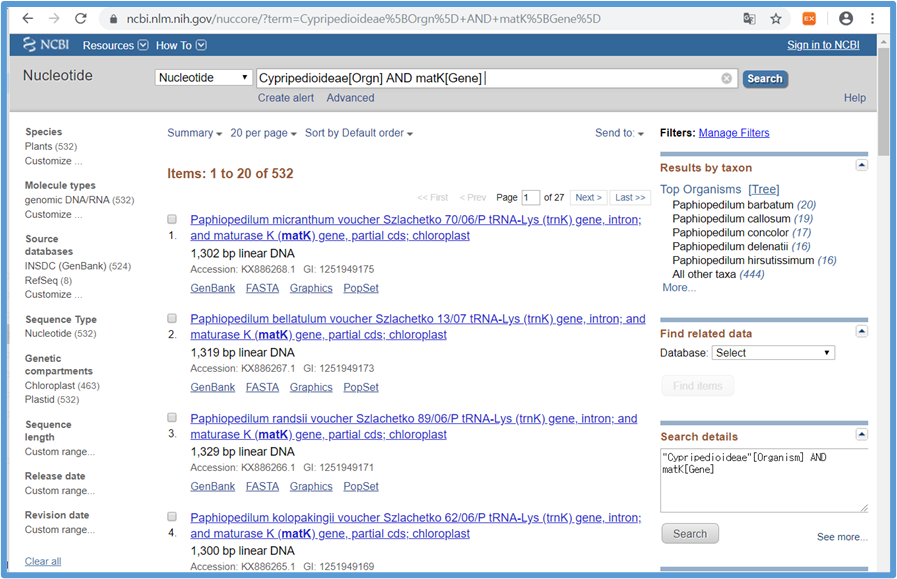

In [88]:
import Bio
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
handle = Entrez.esearch(db="nucleotide", term="Cypripedioideae[Orgn] AND matK[Gene]")
record = Entrez.read(handle)
print(record["Count"])
print(record["IdList"])

835
['2248507675', '2252658351', '2248507758', '2307919923', '2319117367', '2452623409', '2431509302', '2431509223', '2431509146', '2431509069', '2431508992', '2431508914', '2431508837', '2431508760', '2431508683', '2431508606', '2431508530', '2431508453', '2431508376', '2431508299']


## [실습] NLM Catalog 데이터베이스에서 논문이름에 ‘computational’이 들어가는 논문리스트를 검색하는 파이썬 코드를 작성해 보자.

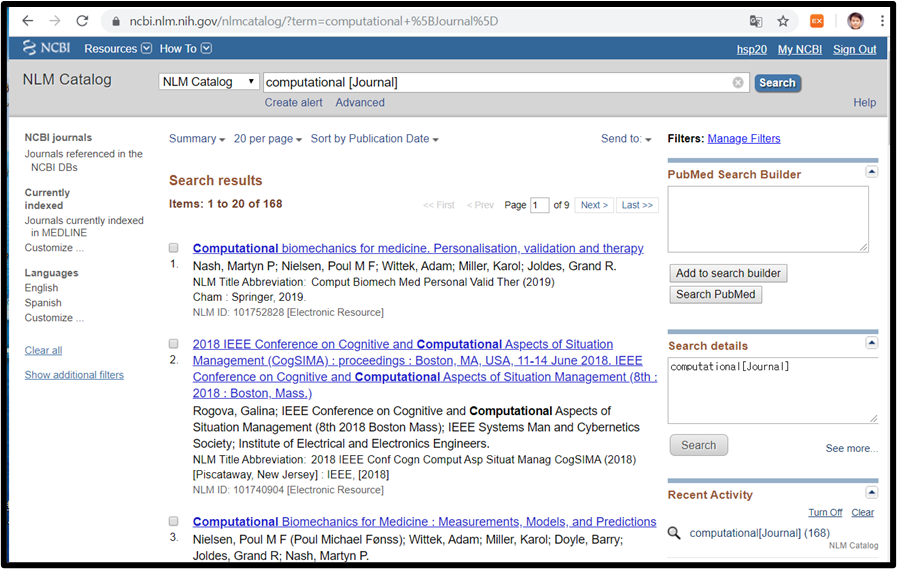

In [89]:
import Bio
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
handle = Entrez.esearch(db="nlmcatalog", term="computational [Journal]", retmax="20")
record = Entrez.read(handle)
print("Computaional keyword found in {} Journals.".format(record["Count"]))
print("THe first 20 are \n {}".format(record["IdList"]))

Computaional keyword found in 193 Journals.
THe first 20 are 
 ['474444', '101775780', '101775476', '101775136', '471899', '470813', '297158', '203194', '96920', '388333', '101768752', '101765300', '101759185', '101752828', '296882', '101768811', '101755127', '101753951', '101753371', '101737789']


## [실습] GenBank EU490707 레코드를 다운 받는 파이썬 코드를 작성해 보자.

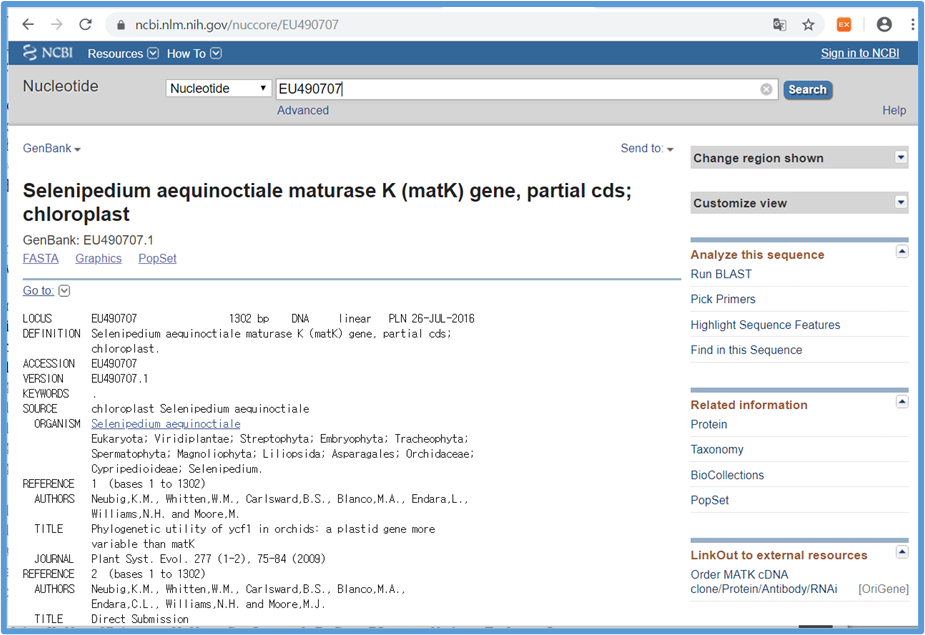

In [90]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.efetch(db="nucleotide", id="EU490707", rettype="gb", retmode="text")
print(handle.read())

LOCUS       EU490707                1302 bp    DNA     linear   PLN 26-JUL-2016
DEFINITION  Selenipedium aequinoctiale maturase K (matK) gene, partial cds;
            chloroplast.
ACCESSION   EU490707
VERSION     EU490707.1
KEYWORDS    .
SOURCE      chloroplast Selenipedium aequinoctiale
  ORGANISM  Selenipedium aequinoctiale
            Eukaryota; Viridiplantae; Streptophyta; Embryophyta; Tracheophyta;
            Spermatophyta; Magnoliopsida; Liliopsida; Asparagales; Orchidaceae;
            Cypripedioideae; Selenipedium.
REFERENCE   1  (bases 1 to 1302)
  AUTHORS   Neubig,K.M., Whitten,W.M., Carlsward,B.S., Blanco,M.A., Endara,L.,
            Williams,N.H. and Moore,M.
  TITLE     Phylogenetic utility of ycf1 in orchids: a plastid gene more
            variable than matK
  JOURNAL   Plant Syst. Evol. 277 (1-2), 75-84 (2009)
REFERENCE   2  (bases 1 to 1302)
  AUTHORS   Neubig,K.M., Whitten,W.M., Carlsward,B.S., Blanco,M.A.,
            Endara,C.L., Williams,N.H. and Moore,M.J.
  TIT

## [실습] BioPython에 관한 논문 타이틀 알아 내기

In [91]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(db="pubmed", term="biopython")
record = Entrez.read(handle)
idlist = record["IdList"]
for index in range(0, len(idlist)):
    listID = idlist[index]
    handle = Entrez.esummary(db='pubmed', id=listID)
    record = Entrez.read(handle)
    print(index, record[0]["Title"], record[0]["HasAbstract"])

0 Applying a modified metabarcoding approach for the sequencing of macrofungal specimens from fungarium collections. IntegerElement(1, attributes={})
1 Energy Profile Bayes and Thompson Optimized Convolutional Neural Network protein structure prediction. IntegerElement(1, attributes={})
2 Jupytope: computational extraction of structural properties of viral epitopes. IntegerElement(1, attributes={})
3 Trends in dermatology eponyms. IntegerElement(1, attributes={})
4 A bioinformatic pipeline for simulating viral integration data. IntegerElement(1, attributes={})
5 rbcL gene in global molecular data repository. IntegerElement(1, attributes={})
6 Analysis of 329,942 SARS-CoV-2 records retrieved from GISAID database. IntegerElement(1, attributes={})
7 Identification of Immune-Related Genes in Sepsis due to Community-Acquired Pneumonia. IntegerElement(1, attributes={})
8 A Biopython-based method for comprehensively searching for eponyms in Pubmed. IntegerElement(1, attributes={})
9 Correlati

## [실습] Pubmed 데이터베이스에서 ‘biopython’ 키워드로 논문을 검색하는 파이썬 코드를 작성해 보자.

Instead of parsing Medline records stored in files, you can also parse Medline records downloaded by `Bio.Entrez.efetch`.
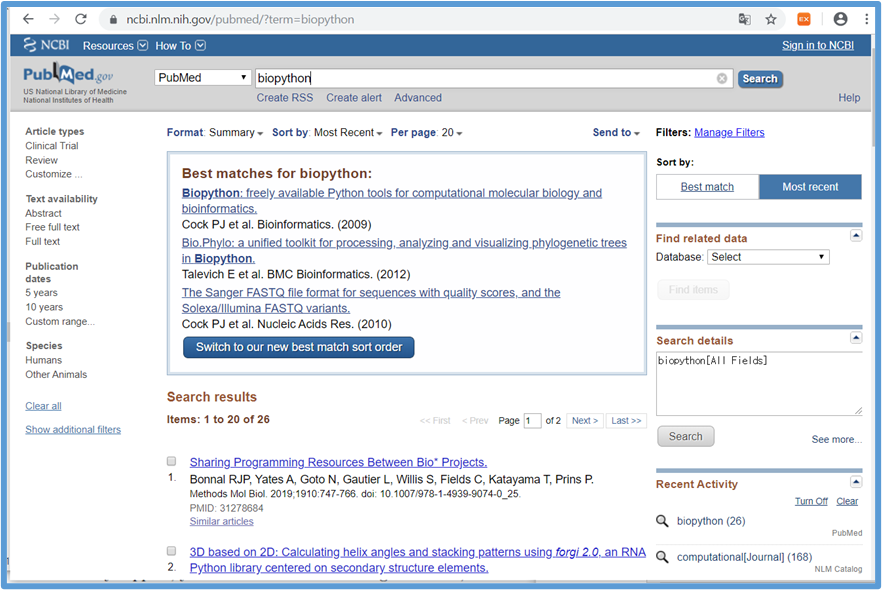

In [92]:
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(db="pubmed", term="biopython")
record = Entrez.read(handle)
print(record["IdList"])

idlist = record["IdList"]
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")

from Bio import Medline
records = Medline.parse(handle)
for record in records:
    print(record["AU"])

['36818783', '36245797', '36094101', '35497637', '35496474', '35402671', '34735950', '34484417', '34434786', '34189012', '33994075', '33902722', '33809815', '33242467', '32044951', '31762715', '31278684', '31069053', '30013827', '29641230']
['Olds CG', 'Berta-Thompson JW', 'Loucks JJ', 'Levy RA', 'Wilson AW']
['Nallasamy V', 'Seshiah M']
['Rashid S', 'Ng TA', 'Kwoh CK']
['He L', 'Cornish TC', 'Kricka LJ', 'Vandergriff TW', 'Yancey K', 'Nguyen K', 'Park JY']
['Scott S', 'Grigson S', 'Hartkopf F', 'Hallwirth CV', 'Alexander IE', 'Bauer DC', 'Wilson LOW']
['Omonhinmin C', 'Onuselogu C']
['Zelenova M', 'Ivanova A', 'Semyonov S', 'Gankin Y']
['Li Y', 'Wang J', 'Li Y', 'Liu C', 'Gong X', 'Zhuang Y', 'Chen L', 'Sun K']
['Cornish TC', 'Kricka LJ', 'Park JY']
['Purohit S', 'Satapathy SC', 'Sibi Chakkaravarthy S', 'Zhang YD']
['Floch A', 'Teletchea S', 'Tournamille C', 'de Brevern AG', 'Pirenne F']
['Torkian B', 'Hann S', 'Preisner E', 'Norman RS']
['Ochoa R', 'Cossio P']
['Kricka LJ', 'Cornish 

In [93]:
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="xml")
records = Entrez.read(handle)
for record in records["PubmedArticle"]:
    print(record["MedlineCitation"]["Article"]["ArticleTitle"])

Applying a modified metabarcoding approach for the sequencing of macrofungal specimens from fungarium collections.
Energy Profile Bayes and Thompson Optimized Convolutional Neural Network protein structure prediction.
Jupytope: computational extraction of structural properties of viral epitopes.
Trends in dermatology eponyms.
A bioinformatic pipeline for simulating viral integration data.
<i>rbcL</i> gene in global molecular data repository.
Analysis of 329,942 SARS-CoV-2 records retrieved from GISAID database.
Identification of Immune-Related Genes in Sepsis due to Community-Acquired Pneumonia.
A Biopython-based method for comprehensively searching for eponyms in Pubmed.
Correlation-Based Analysis of COVID-19 Virus Genome Versus Other Fatal Virus Genomes.
A Review of the Literature Organized Into a New Database: RHeference.
BLAST-QC: automated analysis of BLAST results.
PepFun: Open Source Protocols for Peptide-Related Computational Analysis.
Eponyms in clinical chemistry.
atomium-a P

## [실습] PubMed에서 orchids에 대한 모든 논문을 다운 받아 파일에 저장해 보자.

In [94]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com" # Always tell NCBI who you are
handle = Entrez.esearch(db="pubmed", term="orchid", retmax=463)
record = Entrez.read(handle)
handle.close()
idlist = record["IdList"]

from Bio import Medline
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
records = Medline.parse(handle)
records = list(records)

curdir = "medline/"
i = 0
for record in records:
    f = open(curdir+"orchid_"+str(idlist[i])+".txt", "w")

    f.write("ID:" + idlist[i])
    f.write("title:" + record.get("TI", "?"))
    f.write("authors:" + ','.join(record.get("AU", "?"))) # type(record.get("AU", "?") return 'list'
    f.write("source:" + record.get("SO", "?"))
    f.write("abstract:" + record.get("AB", "?"))
    
    f.close()
    i += 1

## [실습] 5개 정도의 바이오인포매틱스 관련 저널들의, 2020년 이후 저널  Id 리스트를 다운 받아 보자. 

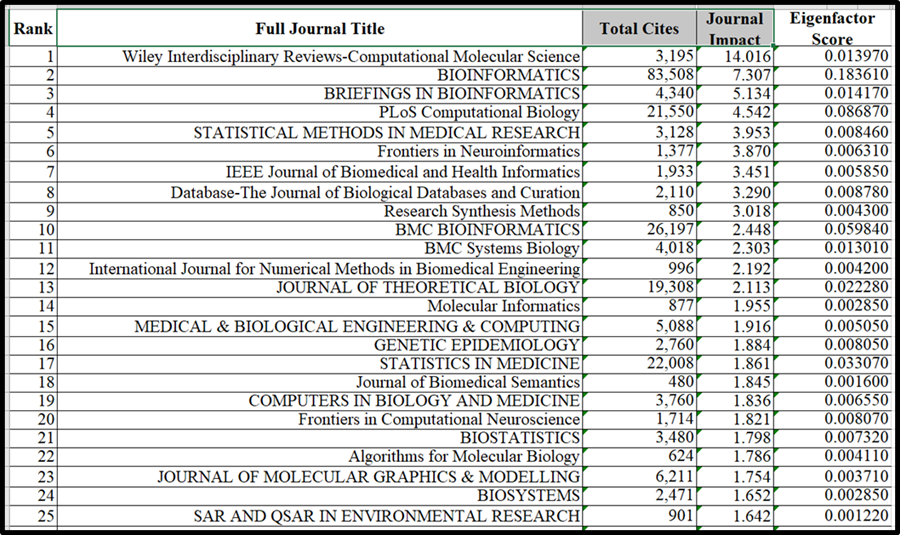

In [95]:
# find article about 'epigenetics' published in 2020 from Pubmed and write output text file named pubmed id. 
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
handle = Entrez.esearch(db='pubmed', term='epigenetics', year='2020')
record = Entrez.read(handle)

for idx in range(len(record["IdList"])):
    if idx > 5:
        break

    field = record["IdList"][idx]
    id_handle = Entrez.efetch(db="pubmed",id=field,rettype="null",retmode="xml")
    id_record = Entrez.read(id_handle)
    abstract = id_record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
    title = id_record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle']
    print(title)
    out = open("%s.txt"%field,'w', encoding='utf-8')
    out.write("%s\n%s"%(title,abstract))
    out.close()

The germinal center in the pathogenesis of B cell lymphomas.
BRD4 inhibition sensitizes diffuse large B-cell lymphoma cells to ferroptosis.
Gibberellin signaling modulates flowering via the DELLA-BRAHMA-NF-YC module in Arabidopsis.
Co-option of endogenous retroviruses through genetic escape from TRIM28 repression.
Inhibition of DNA and RNA methylation disturbs root development of moso bamboo.
Epigenomics in stress tolerance of plants under the climate change.


In [96]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
for year in range(2000,2015):
        handle = Entrez.esearch(db='pubmed', term='epigenetics', year=str(year))
        record = Entrez.read(handle)
        print(year, len(record["IdList"]))

2000 20
2001 20
2002 20
2003 20
2004 20
2005 20
2006 20
2007 20
2008 20
2009 20
2010 20
2011 20
2012 20
2013 20
2014 20


## [실습] NLTK (Natural Language Processing Toolkit) 설치하기

In [97]:
!pip install nltk

In [98]:
import nltk
nltk.__file__

'/home/leejh/anaconda3/lib/python3.9/site-packages/nltk/__init__.py'

## 코퍼스 (Corpus) 구축하기

In [99]:
from nltk.corpus import PlaintextCorpusReader
corpus_root = '/usr/share/dict'
wordlists = PlaintextCorpusReader(corpus_root, '.*')
print(wordlists.fileids())
print(wordlists.words('american-english')) # print(wordlists.words('connectives'))

['README.select-wordlist', 'american-english', 'british-english', 'cracklib-small', 'words', 'words.pre-dictionaries-common']
['A', 'A', "'", 's', 'AMD', 'AMD', "'", 's', 'AOL', ...]


## [실습] orchid 관련 메드라인 문헌들을, nltk를 활용하여, 코퍼스로 만들어 보자.

In [100]:
import nltk
from nltk import corpus
from nltk.corpus import *
corpus_root = "./medline"
orchid_corpus = PlaintextCorpusReader(corpus_root, ".*\.txt", encoding="utf-8")
orchid_corpus.fileids()
orchid_corpus.raw('orchid_34951552.txt')

'ID:34951552title:The experiences and beliefs of people with severe haemophilia and healthcare professionals on pain management, and their views of using exercise as an aspect of intervention: a qualitative study.authors:McLaughlin P,Hurley M,Chowdary P,Stephensen D,Khair Ksource:Disabil Rehabil. 2022 Dec;44(26):8420-8428. doi: 10.1080/09638288.2021.2018054. Epub 2021 Dec 24.abstract:PURPOSE: To explore the experiences, views and beliefs of people with severe haemophilia and healthcare professionals (HCPs) on approaches for pain management, as well as their views on exercise being used as an aspect of management. METHODS: Taking a qualitative inquiry approach using focus groups and semi-structured interviews, participants included people with severe haemophilia living with chronic pain and haemophilia HCPs. Data were analysed using reflexive thematic analysis. RESULTS: Fourteen men with haemophilia with a median age of 47 (range 23-73) and six haemophilia HCPs agreed to participate. Of

## [실습] 코퍼스로 만든 후 raw(), words(), sents() 함수 사용해 보기

Each corpus reader provides a variety of methods to read data from the corpus, depending on the format of the corpus. For example, plaintext corpora support methods to read the corpus as raw text, a list of words, a list of sentences, or a list of paragraphs.

In [101]:
import nltk
from nltk import corpus
from nltk.corpus import *
corpus_root = "./medline"
orchid_corpus = PlaintextCorpusReader(corpus_root, ".*\.txt", encoding="utf-8")
raw = orchid_corpus.raw('orchid_34951552.txt')
print(raw[1:100])
word = orchid_corpus.words('orchid_34951552.txt')
print(word[1:20])
sent = orchid_corpus.sents('orchid_34951552.txt')
#print(sent[:2])

D:34951552title:The experiences and beliefs of people with severe haemophilia and healthcare profes
[':', '34951552title', ':', 'The', 'experiences', 'and', 'beliefs', 'of', 'people', 'with', 'severe', 'haemophilia', 'and', 'healthcare', 'professionals', 'on', 'pain', 'management', ',']


## [실습] Orchid 코퍼스 파일 별 글자수, 단어수, 문장 수 통계 내기

In [102]:
import nltk
from nltk import corpus
from nltk.corpus import *
corpus_root = "./medline"
orchid_corpus = PlaintextCorpusReader(corpus_root, ".*\.txt", encoding="utf-8")
for file in orchid_corpus.fileids():
    print(file, ":", len(orchid_corpus.raw(file)), len(orchid_corpus.words(file)))

orchid_34951552.txt : 2631 452
orchid_34956293.txt : 2499 428
orchid_34961250.txt : 1140 219
orchid_34963417.txt : 2519 439
orchid_34963822.txt : 1814 333
orchid_34975938.txt : 2114 397
orchid_34975981.txt : 1641 284
orchid_34977459.txt : 2079 421
orchid_34983403.txt : 2188 408
orchid_34992588.txt : 2460 443
orchid_34993702.txt : 2490 446
orchid_34997964.txt : 1948 434
orchid_34998029.txt : 2446 424
orchid_35002359.txt : 936 195
orchid_35007450.txt : 1069 211
orchid_35020417.txt : 2044 389
orchid_35020908.txt : 2052 424
orchid_35024073.txt : 2940 552
orchid_35024514.txt : 1357 265
orchid_35028741.txt : 2512 455
orchid_35035631.txt : 2727 543
orchid_35042128.txt : 298 73
orchid_35052412.txt : 1637 309
orchid_35056523.txt : 1667 287
orchid_35065204.txt : 384 105
orchid_35065871.txt : 1869 354
orchid_35086477.txt : 2621 475
orchid_35095948.txt : 2010 349
orchid_35095954.txt : 2253 379
orchid_35099667.txt : 2027 356
orchid_35100375.txt : 1971 376
orchid_35104310.txt : 1321 229
orchid_35116

## [실습] orchid corpus의 단어 중, 단어의 길이가 15 이상의 긴 단어들을 모두 찾아라.

In [103]:
import nltk
from nltk import corpus
from nltk.corpus import *
corpus_root = "./medline"
orchid_corpus = PlaintextCorpusReader(corpus_root, ".*\.txt", encoding="utf-8")
raw = orchid_corpus.raw()
print(len(raw))
word = orchid_corpus.words()
print(len(word))
longWords = [w for w in set(word) if len(w) >= 20]
print(longWords)

985771
185518
['Maxillariaanacatalinaportillae', 'Dendrobiumofficinale', 'ETHNOPHARMACOLOGICAL', 'microorganisms10051006', 'anacatalinaportillae', 'thiodioxopiperazines', 'Cyclopropanecarboxylic', 'benzyltetrahydroisoquinoline', 'acetylcholinesterase', 'microorganisms10091841', 'ethnopharmacological', 'paleopolyploidization', 'allopolyploidizations', 'tetrahydrocannabinol', '1872208316666220415124439', 'homocyclotirucallane', 'Curvicladiellapaphiopedili', 'dichlorophenoxyacetic', 'microorganisms10010072', 'rehabilitationMusculoskeletal', 'neofunctionalization', 'Bispyrrolidinoindoline', 'nonfunctionalization', 'Dipterisshenzhenensis', 'TTAGGAAGAGGTCCAAGTAAG', 'hydroxymethylpyrazines', 'dihydrophenanthrenes', 'ATGTCTTACACTATTACAGACC', 'Aphyllorchisperiactinantha', 'rhamnosylgalactoside', 'compartmentalization', 'holomycoheterotrophic', 'Dichlorophenoxyacetic', 'Phalaenopsismedogensis', 'Euglossaheterosticta', 'subfunctionalization', 'trimethoxyphenanthrene', 'GoodyerasubsectionReticulum